# Jonathan Halverson
# Friday, December 29, 2017
# Variational autoencoder (a generative autoencoder)

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/tmp/data/')

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


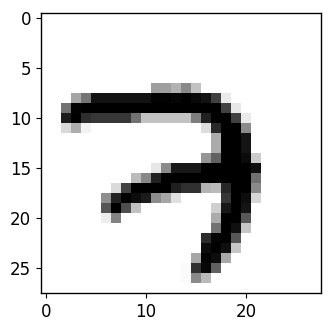

In [3]:
plt.imshow(mnist.train.images[0].reshape(28, 28), cmap='binary')

Most of the code below was taken directly from Geron:

In [4]:
from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()
my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_gamma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_gamma), dtype=tf.float32)
hidden3 = hidden3_mean + tf.exp(0.5 * hidden3_gamma) * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)
latent_loss = 0.5 * tf.reduce_sum(tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [5]:
n_digits = 60
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
     init.run()
     for epoch in range(n_epochs):
          n_batches = mnist.train.num_examples // batch_size
          for iteration in range(n_batches):
               X_batch, y_batch = mnist.train.next_batch(batch_size)
               sess.run(training_op, feed_dict={X: X_batch})
          loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch})
          print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)
          saver.save(sess, "/tmp/data/my_model_variational.ckpt")
     codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
     outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

('\r0', 'Train total loss:', 18289.914, '\tReconstruction loss:', 14563.603, '\tLatent loss:', 3726.3113)
('\r1', 'Train total loss:', 16539.758, '\tReconstruction loss:', 12881.113, '\tLatent loss:', 3658.6436)
('\r2', 'Train total loss:', 16646.496, '\tReconstruction loss:', 12949.854, '\tLatent loss:', 3696.6421)
('\r3', 'Train total loss:', 15781.445, '\tReconstruction loss:', 12178.086, '\tLatent loss:', 3603.3591)
('\r4', 'Train total loss:', 16162.863, '\tReconstruction loss:', 12416.749, '\tLatent loss:', 3746.1143)
('\r5', 'Train total loss:', 15826.936, '\tReconstruction loss:', 12156.954, '\tLatent loss:', 3669.9819)
('\r6', 'Train total loss:', 16158.357, '\tReconstruction loss:', 12350.098, '\tLatent loss:', 3808.2598)
('\r7', 'Train total loss:', 16036.539, '\tReconstruction loss:', 12246.172, '\tLatent loss:', 3790.3667)
('\r8', 'Train total loss:', 15485.625, '\tReconstruction loss:', 11636.462, '\tLatent loss:', 3849.1631)
('\r9', 'Train total loss:', 15500.095, '\tRec

We can visualize the the generated digits as follows:

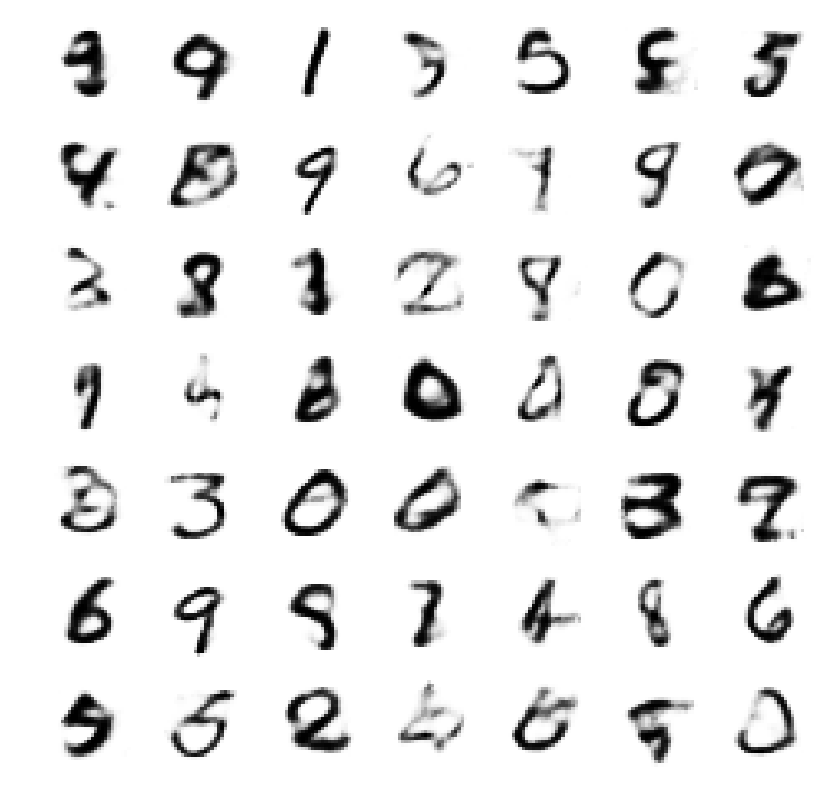

In [13]:
_ = plt.subplots(figsize=(10, 10))
ct = 1
for i in range(1, 8):
     for j in range(1, 8):
          plt.subplot(7, 7, ct)
          plt.imshow(outputs_val[ct].reshape(28, 28), cmap='binary')
          plt.axis('off')
          ct += 1